In [349]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


corrientes = pd.read_csv('corrientes.csv')
potencias = pd.read_csv('potencias.csv')

corrientes['timestamp'] = pd.to_datetime(corrientes['timestamp'])
potencias['timestamp'] = pd.to_datetime(potencias['timestamp'])

# Unir los dataframes en base al ID y timestamp
merged_df = pd.merge(corrientes, potencias, on=['id', 'timestamp'])

# Separar la columna de timestamp en año, mes, día, hora, minuto
merged_df['año'] = merged_df['timestamp'].dt.year
merged_df['mes'] = merged_df['timestamp'].dt.month
merged_df['dia'] = merged_df['timestamp'].dt.day
merged_df['hora'] = merged_df['timestamp'].dt.hour
merged_df['minuto'] = merged_df['timestamp'].dt.minute

# Seleccionar y reorganizar las columnas en el formato deseado
final_df = merged_df[['año', 'mes', 'dia', 'hora', 'minuto', 'activa', 'reactiva', 'aparente', 'l1', 'l2', 'l3']]

# Mostrar el dataframe resultante
print(final_df)

         año  mes  dia  hora  minuto  activa  reactiva  aparente     l1  \
0       2021    1    1     0       0  13.584     9.264    16.444  29.16   
1       2021    1    1     0      15  12.492     9.840    15.904  27.30   
2       2021    1    1     0      30  12.468    10.056    16.016  27.12   
3       2021    1    1     0      45  13.032     9.060    15.872  27.18   
4       2021    1    1     1       0  12.540     9.720    15.868  27.12   
...      ...  ...  ...   ...     ...     ...       ...       ...    ...   
117200  2024    5    6     8      45  45.840     3.564    45.980  74.16   
117201  2024    5    6     9       0  52.092     3.084    52.184  77.97   
117202  2024    5    6     9      15  51.996     2.448    52.052  74.55   
117203  2024    5    6     9      30  53.472     2.316    53.524  77.43   
117204  2024    5    6     9      45  59.472     2.280    59.516  82.71   

            l2     l3  
0        25.62  20.85  
1        24.81  20.34  
2        25.56  20.64  
3  

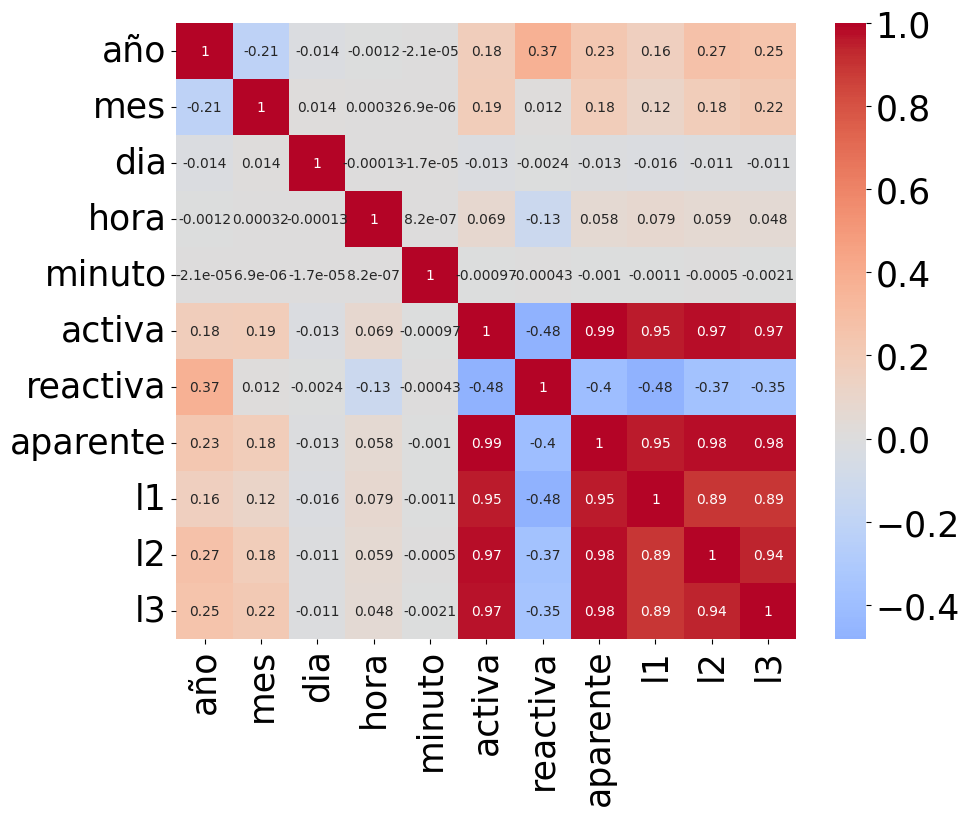

año         0.175960
mes         0.187779
dia        -0.012915
hora        0.068827
minuto     -0.000972
activa      1.000000
reactiva   -0.481186
aparente    0.994164
l1          0.950231
l2          0.972447
l3          0.968129
Name: activa, dtype: float64


In [350]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular la matriz de correlación
corr_matrix = final_df.corr()

# Generar el mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)

# Mostrar el mapa de calor
plt.show()

# Mostrar las correlaciones con la potencia activa
print(corr_matrix['activa'])

<function matplotlib.pyplot.show(close=None, block=None)>

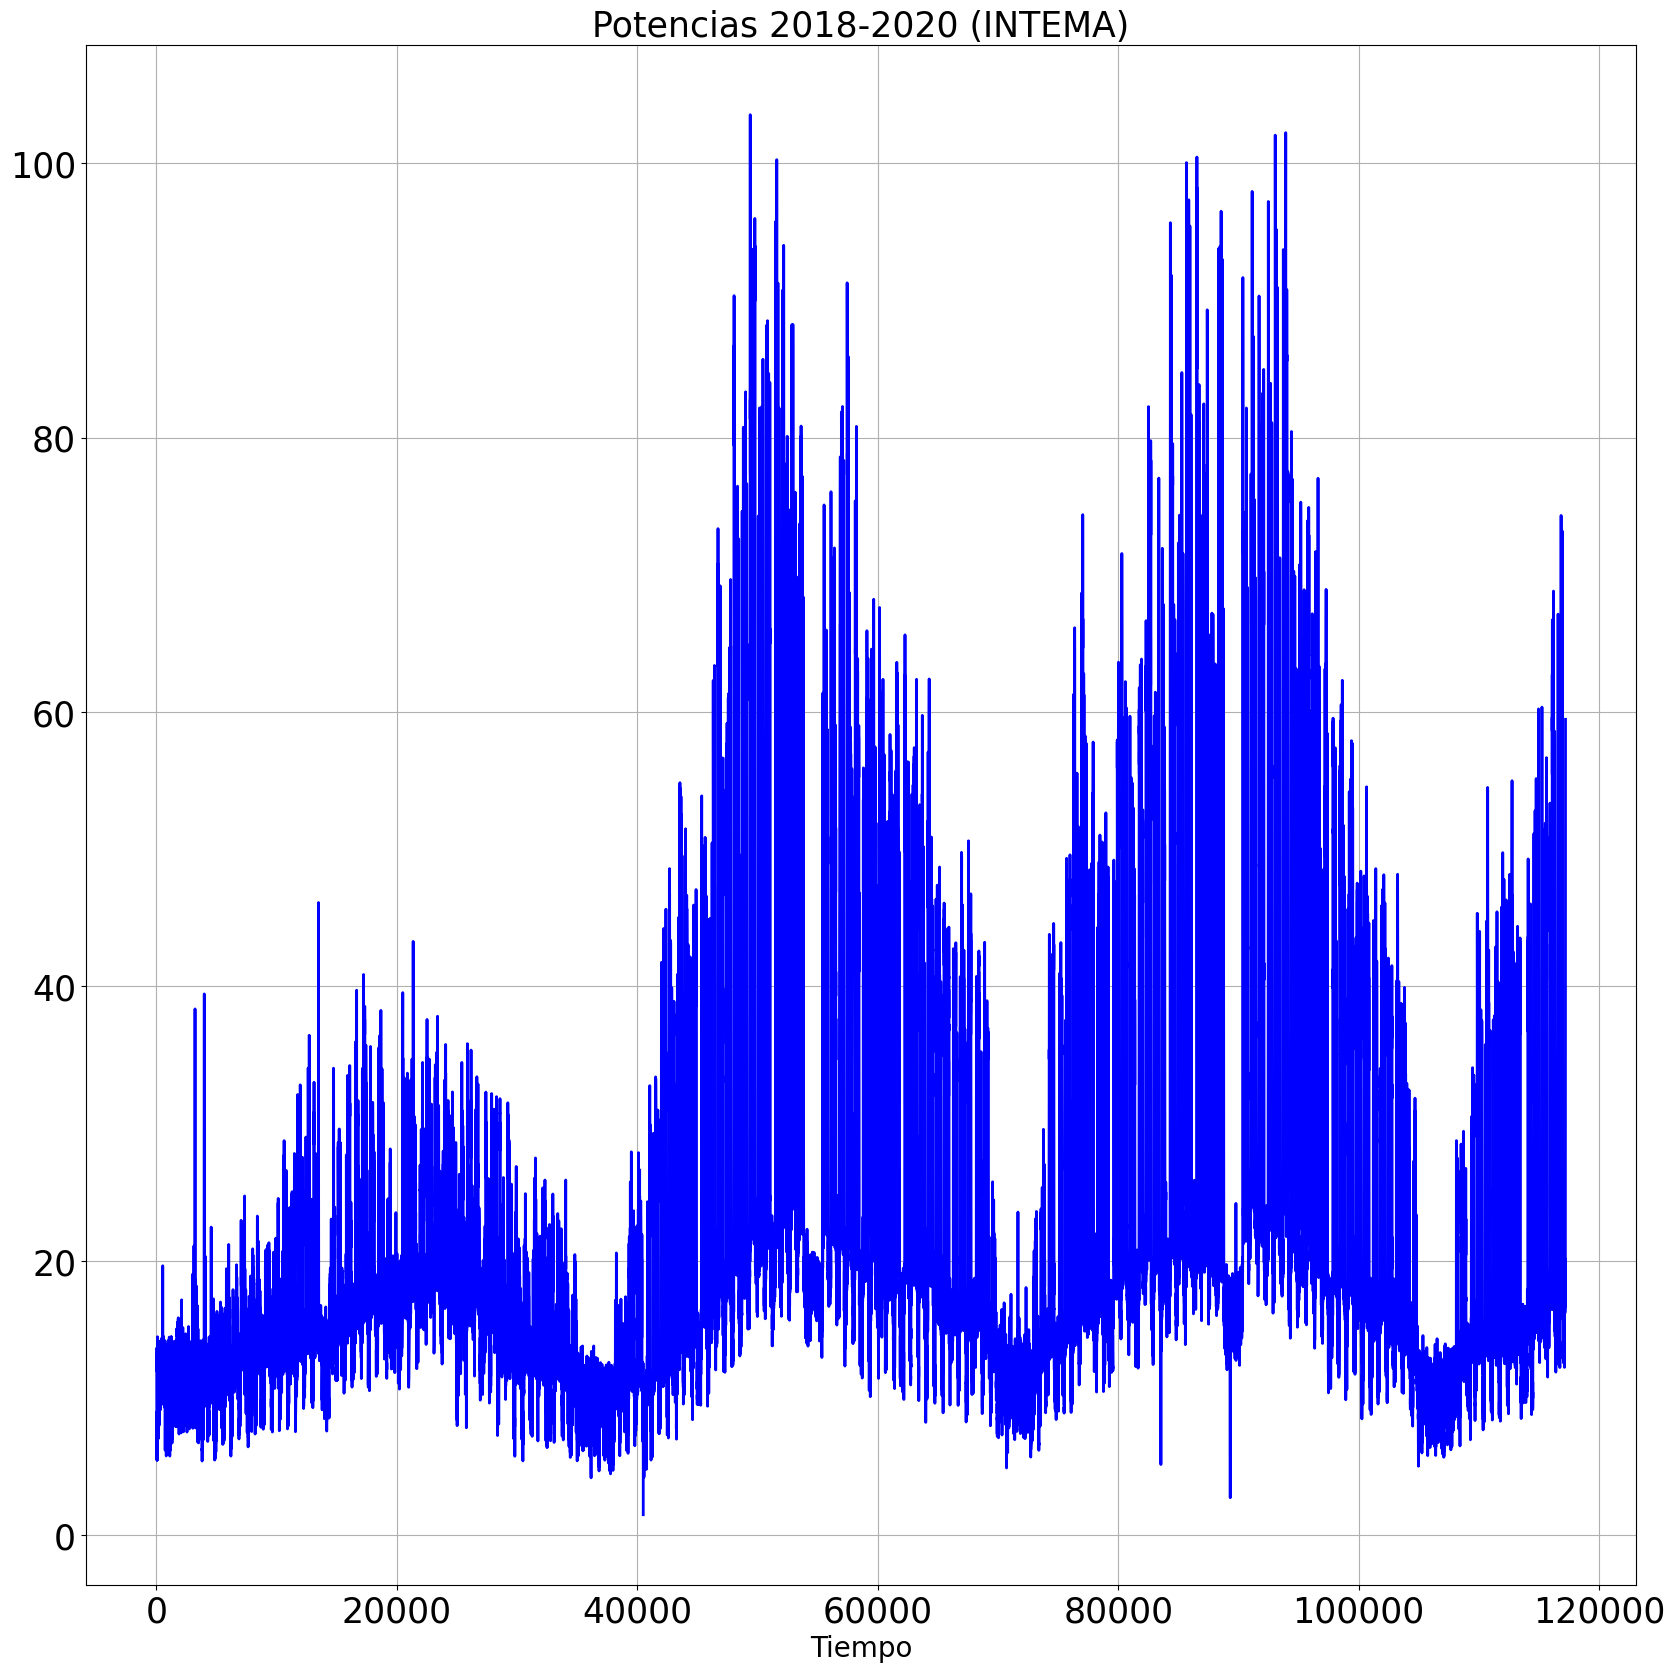

In [351]:
plt.plot(final_df["activa"],'b', linewidth = 2)
plt.rcParams['figure.figsize'] = [20, 20]

plt.grid(True)
plt.title("Potencias 2018-2020 (INTEMA)", fontsize = 25)
plt.xlabel("Tiempo", fontsize = 20)
#plt.ylabel("P [kW]", fontsize = 20)
plt.rc('xtick', labelsize=25) 
plt.rc('ytick', labelsize=25) 
plt.show

In [352]:
final_df_copy = final_df.copy()

In [353]:
# Función para crear ventanas deslizantes
def create_windows(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i+ window_size])  # Indexar correctamente para un array unidimensional
    return np.array(X), np.array(y)

# Crear las ventanas deslizantes
mediciones_ventana = 36


activapre, activapost = create_windows(final_df_copy['activa'], mediciones_ventana)
aparentepre, aparentepost = create_windows(final_df_copy['aparente'], mediciones_ventana)
reactivapre, reactivapost = create_windows(final_df_copy['reactiva'], mediciones_ventana)
mespre, mespost = create_windows(final_df_copy['mes'], mediciones_ventana)
diapre, diapost = create_windows(final_df_copy['dia'], mediciones_ventana)
minutopre, minutopost = create_windows(final_df_copy['minuto'], mediciones_ventana)
i1pre, i1post = create_windows(final_df_copy['l1'], mediciones_ventana)
i2pre, i2post = create_windows(final_df_copy['l2'], mediciones_ventana)
i3pre, i3post = create_windows(final_df_copy['l3'], mediciones_ventana)

#print(activapre)
print(activapost)

[ 8.688  8.46   8.22  ... 51.996 53.472 59.472]


In [354]:
print(activapre)

[[13.584 12.492 12.468 ...  9.756 10.176  9.096]
 [12.492 12.468 13.032 ... 10.176  9.096  8.688]
 [12.468 13.032 12.54  ...  9.096  8.688  8.46 ]
 ...
 [19.752 20.136 19.188 ... 44.292 45.84  52.092]
 [20.136 19.188 19.332 ... 45.84  52.092 51.996]
 [19.188 19.332 19.404 ... 52.092 51.996 53.472]]


In [355]:
#Armamos los datos con el formato que queremos
X = np.concatenate([activapre, aparentepre, reactivapre, mespre, diapre, minutopre, i1pre, i2pre, i3pre], axis=1)
y = activapost  # Supongamos que queremos predecir la 'activa' post ventana



In [356]:
# Proporciones para cada conjunto
train_size = 0.9
val_size = 0.09
test_size = 0.01

# Divide los datos en entrenamiento y temporal (validación + prueba)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(1 - train_size), random_state=4)

# Calcula la proporción de validación y prueba en el conjunto temporal
val_size_temp = val_size / (val_size + test_size)

# Divide el conjunto temporal en validación y prueba
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=(1 - val_size_temp), random_state=45)

# Verifica las formas de los conjuntos
print("Forma de X_train:", X_train.shape)
print("Forma de X_val:", X_val.shape)
print("Forma de X_test:", X_test.shape)
print("Forma de y_train:", y_train.shape)
print("Forma de y_val:", y_val.shape)
print("Forma de y_test:", y_test.shape)

Forma de X_train: (105452, 324)
Forma de X_val: (10545, 324)
Forma de X_test: (1172, 324)
Forma de y_train: (105452,)
Forma de y_val: (10545,)
Forma de y_test: (1172,)


In [357]:

scalerX = StandardScaler()
scalery = StandardScaler()

# Assuming y is a 1D array, reshape it to 2D
y_reshaped = y.reshape(-1, 1)

# Fit and transform X and y_scaled
X_train = scalerX.fit_transform(X_train)
X_val = scalerX.fit_transform(X_val)
X_test = scalerX.fit_transform(X_test)


y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

y_train = scalery.fit_transform(y_train)
y_val = scalery.fit_transform(y_val)
y_test = scalery.fit_transform(y_test)


In [358]:
promedio = np.nanmean(y_train)
# Reemplazar NaN por el promedio calculado
y_train[np.isnan(y_train)] = promedio

promedio = np.nanmean(X_train)
# Reemplazar NaN por el promedio calculado
X_train[np.isnan(X_train)] = promedio

promedio = np.nanmean(X_val)
# Reemplazar NaN por el promedio calculado
X_val[np.isnan(X_val)] = promedio

promedio = np.nanmean(y_val)
# Reemplazar NaN por el promedio calculado
y_val[np.isnan(y_val)] = promedio

promedio = np.nanmean(X_test)
# Reemplazar NaN por el promedio calculado
X_test[np.isnan(X_test)] = promedio

promedio = np.nanmean(y_test)
# Reemplazar NaN por el promedio calculado
y_test[np.isnan(y_test)] = promedio


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 60)                19500     
                                                                 
 dense_49 (Dense)            (None, 42)                2562      
                                                                 
 dense_50 (Dense)            (None, 22)                946       
                                                                 
 dense_51 (Dense)            (None, 1)                 23        
                                                                 
Total params: 23031 (89.96 KB)
Trainable params: 23031 (89.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
3296/3296 [==============================] - 16s 4ms/step - loss: 0.0297 - mae: 0.1037 - val_loss: 0.0187 - val_mae: 0.0929
Epoch 2/10
329

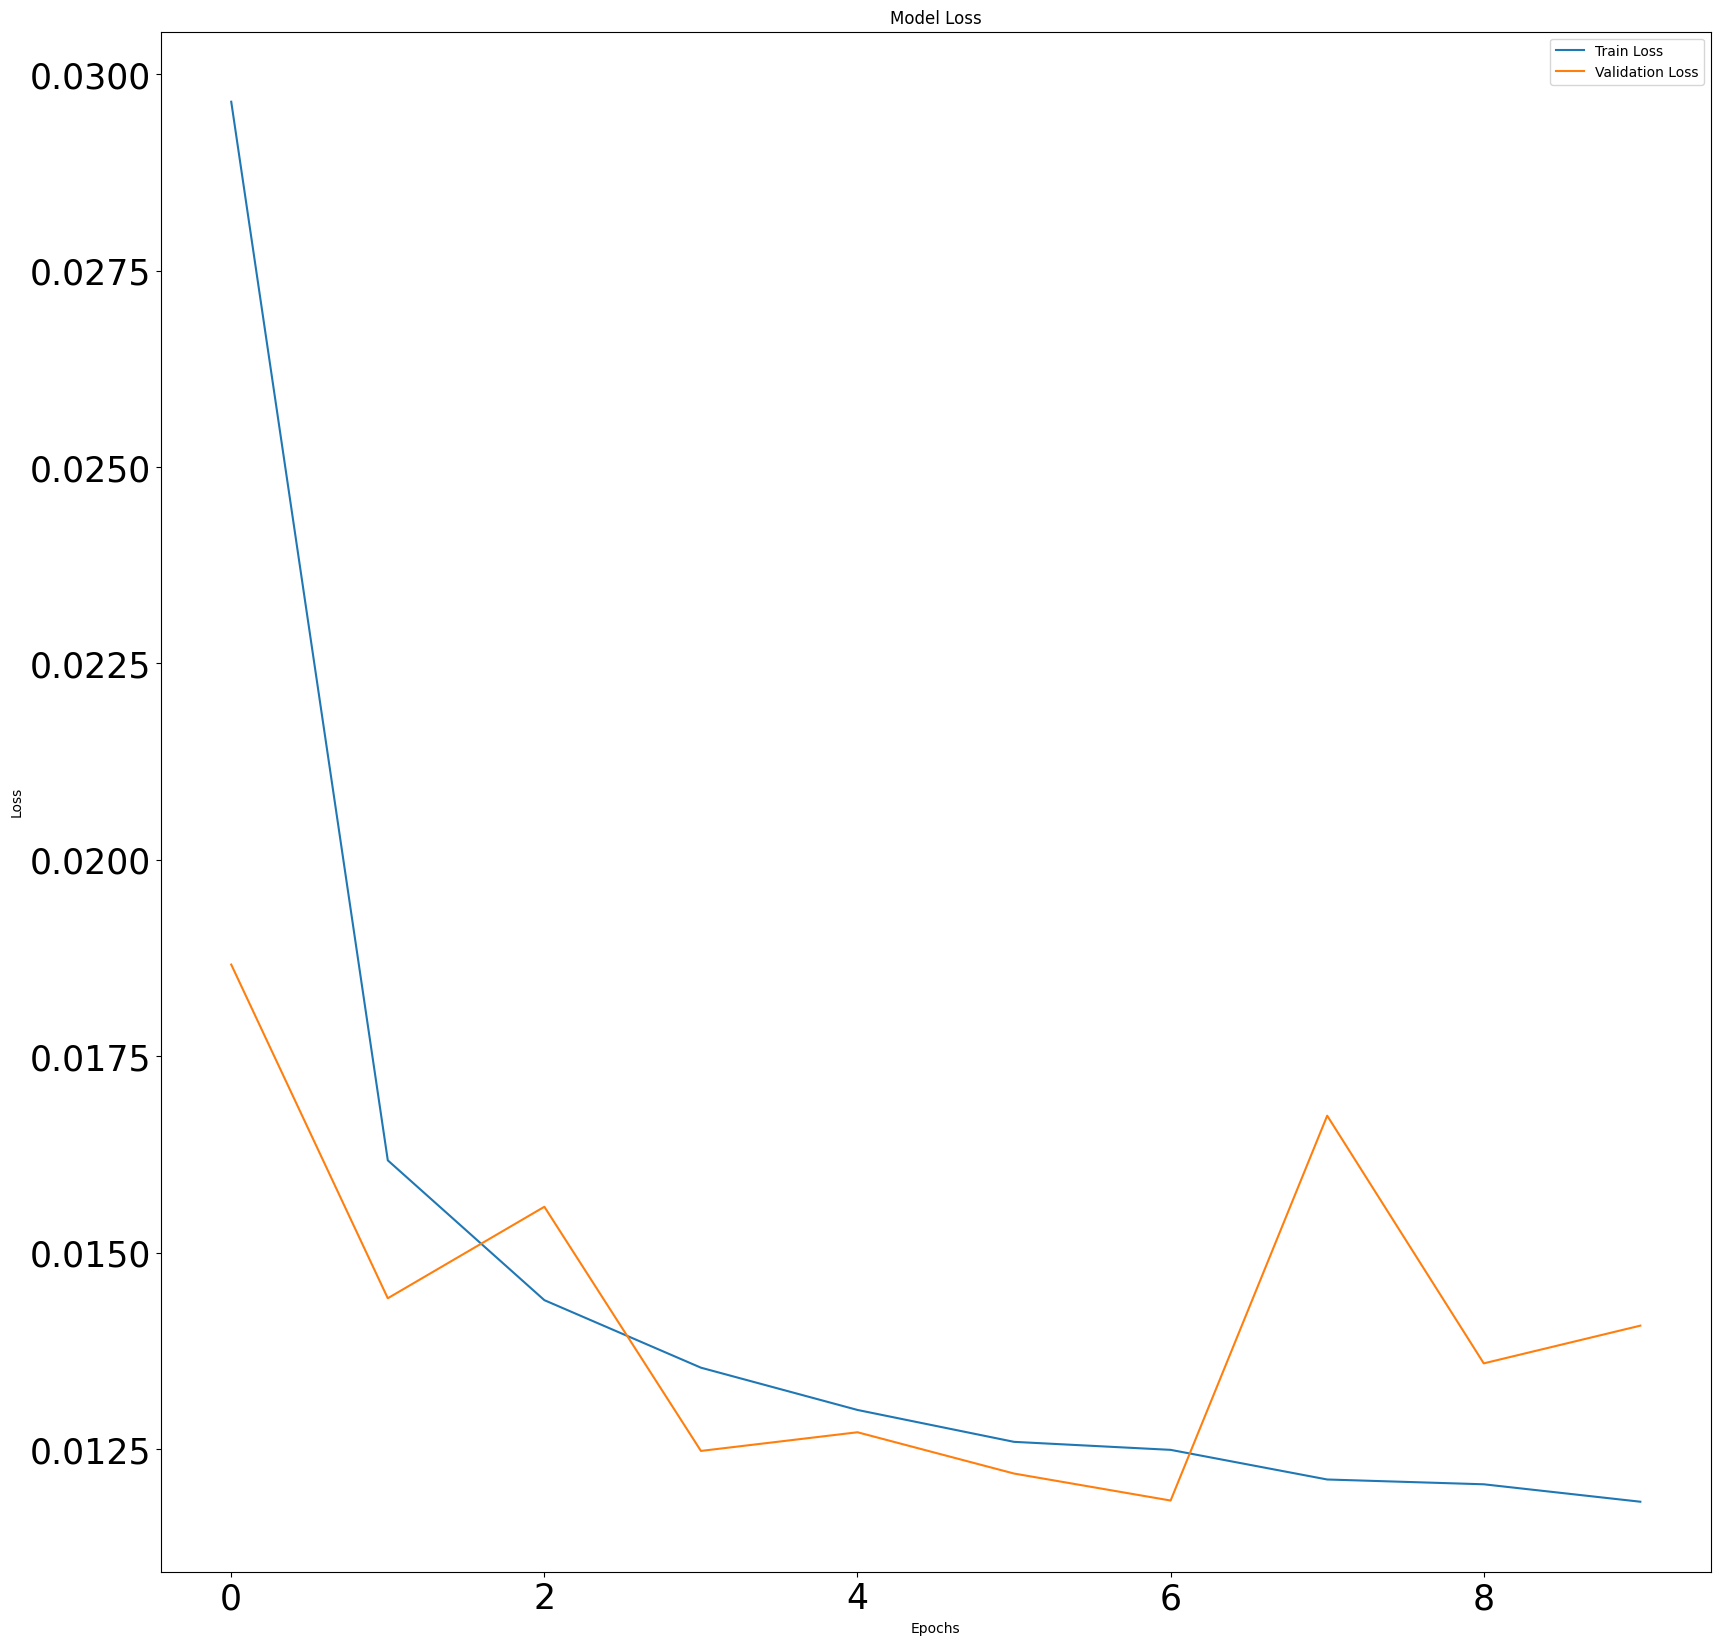

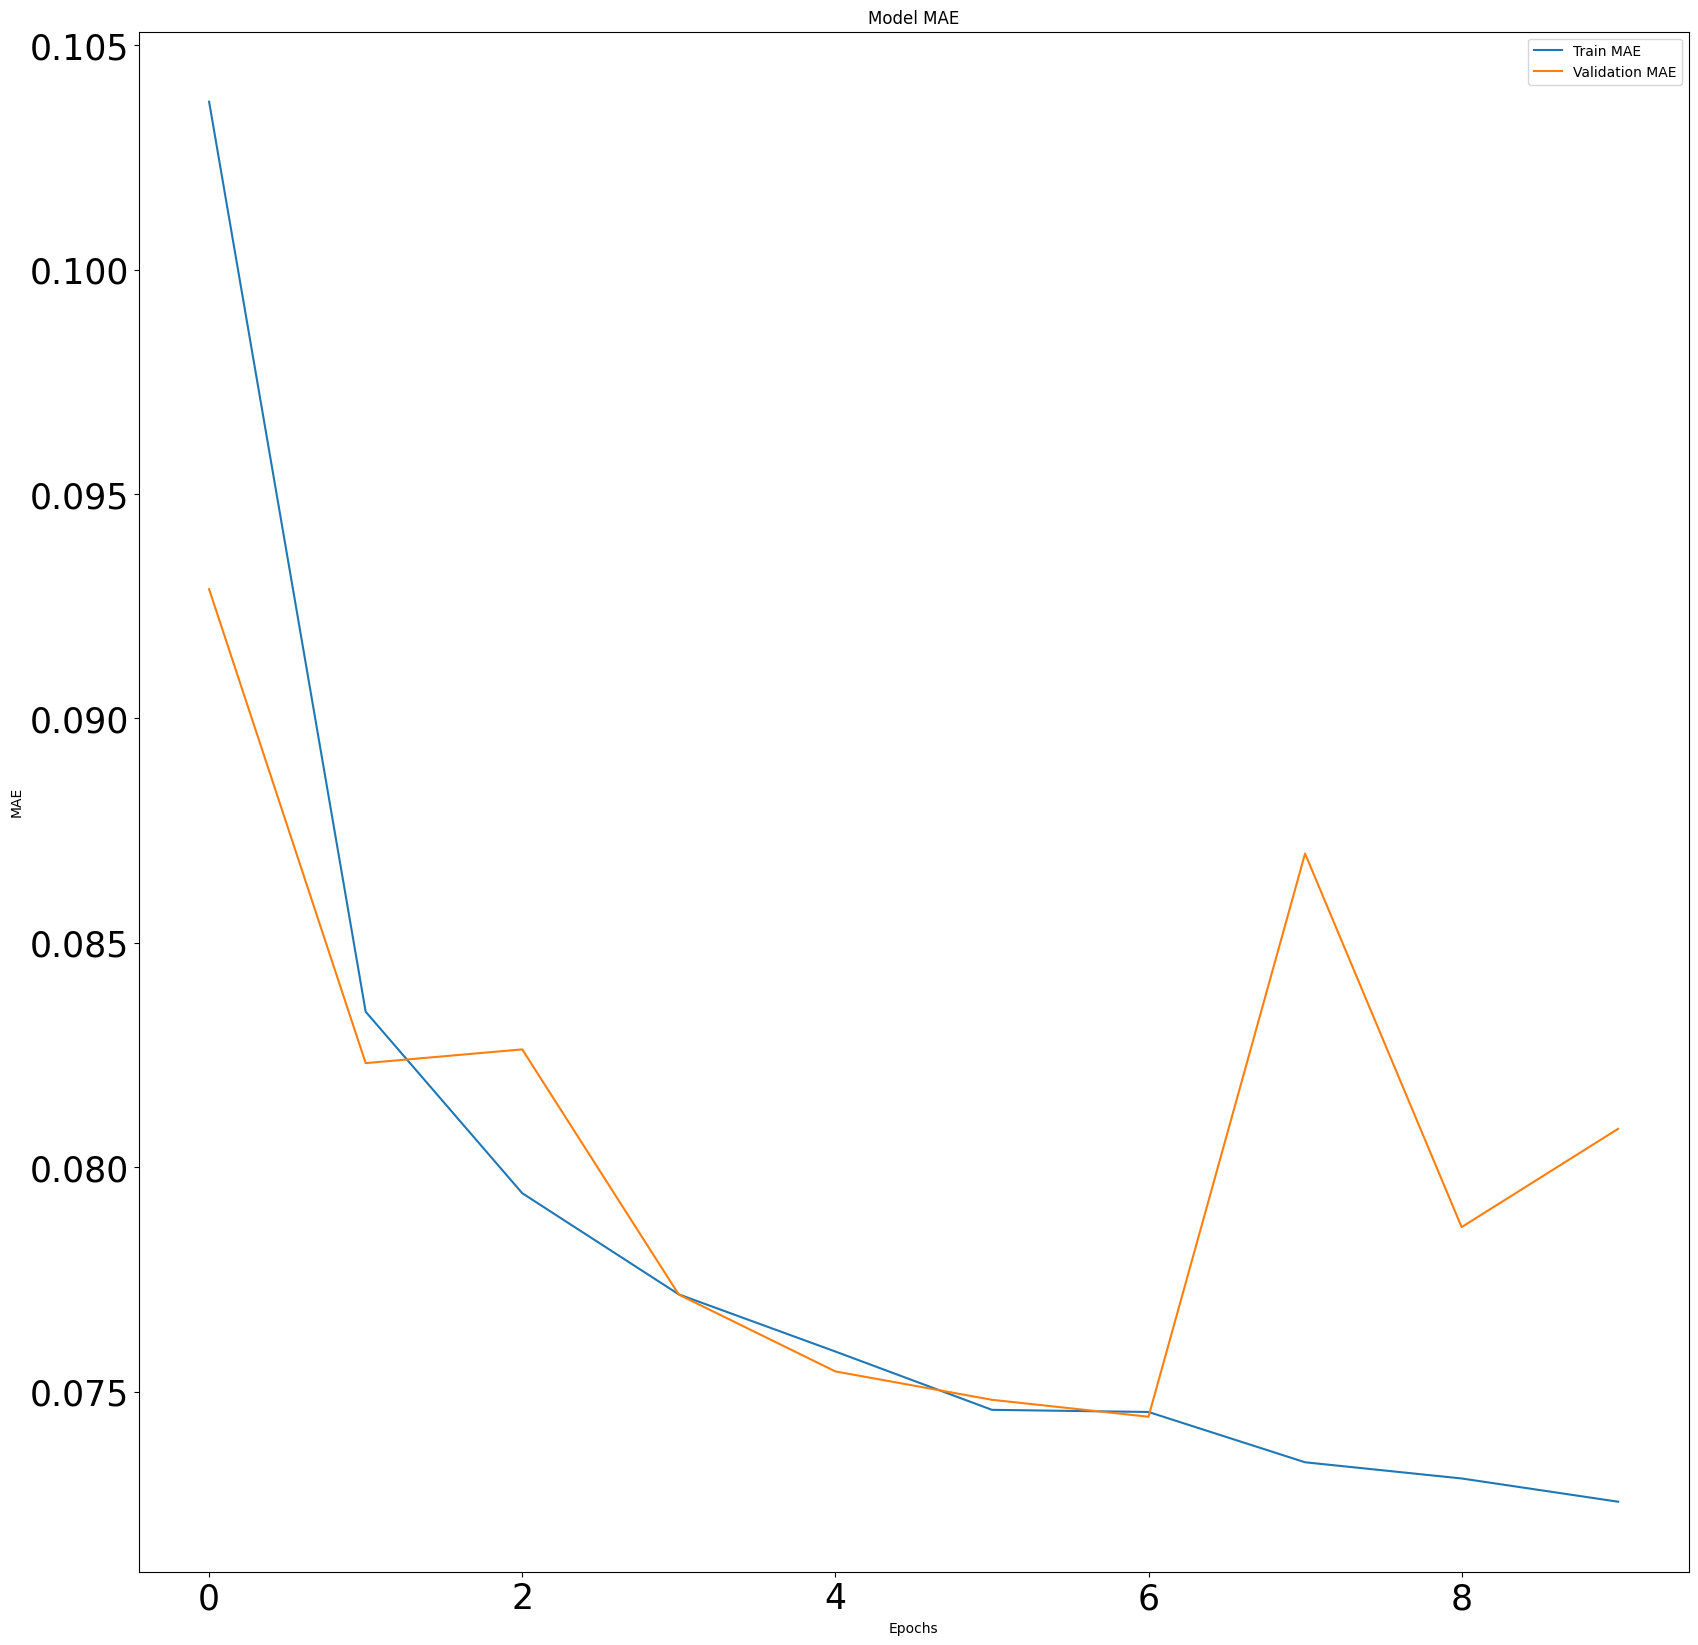

In [371]:
model = Sequential()
model.add(Dense(60, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(42, activation='relu'))
model.add(Dense(22, activation='sigmoid'))
model.add(Dense(1, activation='linear')) # Suponiendo que estás prediciendo un valor continuo

# Definir el optimizador con el learning rate deseado
optimizer = Adam(learning_rate=0.001)

# Compilar el modelo especificando el optimizador y otras configuraciones
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
#model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

model.summary()


#early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
#history = model.fit(X_train, y_train, epochs=2, validation_data=(X_val, y_val), callbacks=[early_stopping],  verbose=1)
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), verbose=1)


# Gráfica de la pérdida
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
#plt.axvline(x=len(history.history['loss']) - early_stopping.patience, color='r', linestyle='--', label='Early Stopping')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Gráfica del MAE
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
#plt.axvline(x=len(history.history['mae']) - early_stopping.patience, color='r', linestyle='--', label='Early Stopping')
plt.title('Model MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [372]:
print(y_test)

[[29.748]
 [53.4  ]
 [55.428]
 ...
 [67.416]
 [14.064]
 [17.952]]


In [361]:
y_test = scalery.inverse_transform(y_test)


In [373]:
y_test_pred = model.predict(X_test[0,:].reshape(1, -1))
print(y_test_pred)

y_test_pred = scalery.inverse_transform(y_test_pred)
print(y_test_pred)

#a = scalery.inverse_transform([-0.07620964])
print("en test esa pos tenia")
print(y_test[0])


1/1 [==============================] - 0s 146ms/step
[[0.8669499]]
[[31.89604]]
en test esa pos tenia
[29.748]


In [374]:
y_test = y_test.reshape(-1, 1)


In [375]:
y_test_pred = y_test_pred.reshape(-1, 1)


print(y_test_pred.shape)
print("este es y test", y_test.shape)

(1, 1)
este es y test (1172, 1)


In [376]:
import numpy as np 
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Supongamos que model es tu modelo ya entrenado y X_test, y_test son tus datos de prueba
# Hacemos predicciones
y_test_pred = model.predict(X_test)




has_nan = np.isnan(y_test_pred).any()
print("¿Hay NaN en los datos y_test_pred?", has_nan)
nan_positions = np.argwhere(np.isnan(y_test_pred))
print("Posiciones de NaN en los datos X:")
print(nan_positions)

y_test_pred[np.isnan(y_test_pred)] = promedio

y_test_pred = scalery.inverse_transform(y_test_pred)





has_nan = np.isnan(y_test).any()
print("¿Hay NaN en los datos y_Test?", has_nan)
nan_positions = np.argwhere(np.isnan(y_test))
print("Posiciones de NaN en los datos X:")
print(nan_positions)

y_test[np.isnan(y_test)] = promedio


# Calculamos el error cuadrático medio (MSE)
mse = mean_squared_error(y_test, y_test_pred)



# Calculamos otras métricas de error
mae = mean_absolute_error(y_test, y_test_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_test_pred)

# Imprimimos las métricas de error
print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'R²: {r2}')

# Definimos un margen de error aceptable (por ejemplo, 10 unidades) 12.45
margin_of_error = 4

# Calculamos cuántas predicciones están dentro del margen de error
within_margin = np.sum(np.abs(y_test - y_test_pred) <= margin_of_error)
total_predictions = len(y_test)
accuracy_within_margin = within_margin / total_predictions

# Imprimimos la precisión dentro del margen de error
print(f'Número de predicciones dentro del margen de error: {within_margin}')
print(f'Precisión dentro del margen de error: {accuracy_within_margin:.2%}')



37/37 [==============================] - 0s 3ms/step
¿Hay NaN en los datos y_test_pred? False
Posiciones de NaN en los datos X:
[]
¿Hay NaN en los datos y_Test? False
Posiciones de NaN en los datos X:
[]
MSE: 2.898789133273935
MAE: 1.0975820592548253
RMSE: 1.7025830767612882
R²: 0.9824329665592785
Número de predicciones dentro del margen de error: 1122
Precisión dentro del margen de error: 95.73%


In [366]:
print(y_test)

[[29.748]
 [53.4  ]
 [55.428]
 ...
 [67.416]
 [14.064]
 [17.952]]


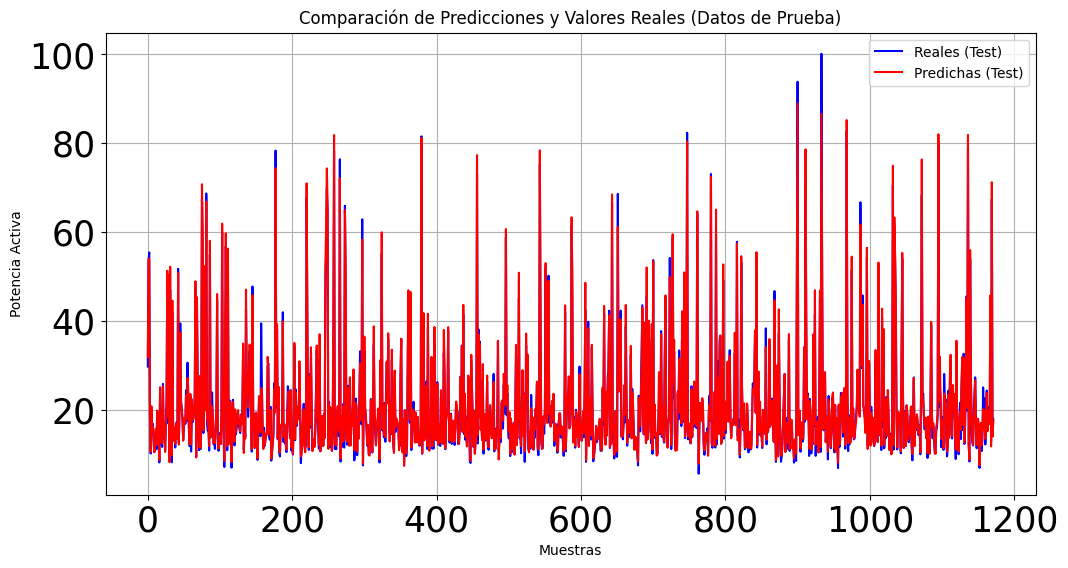

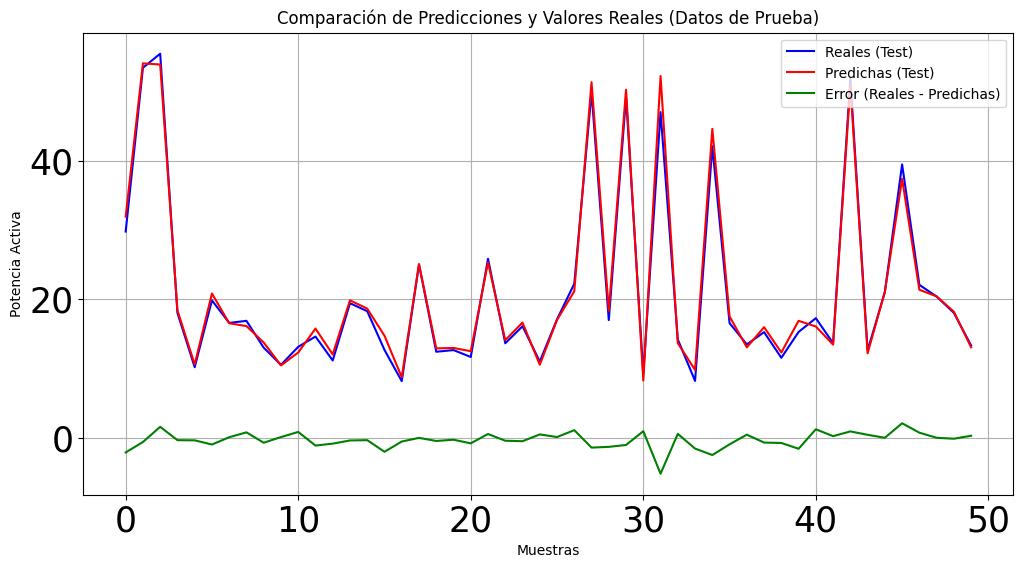

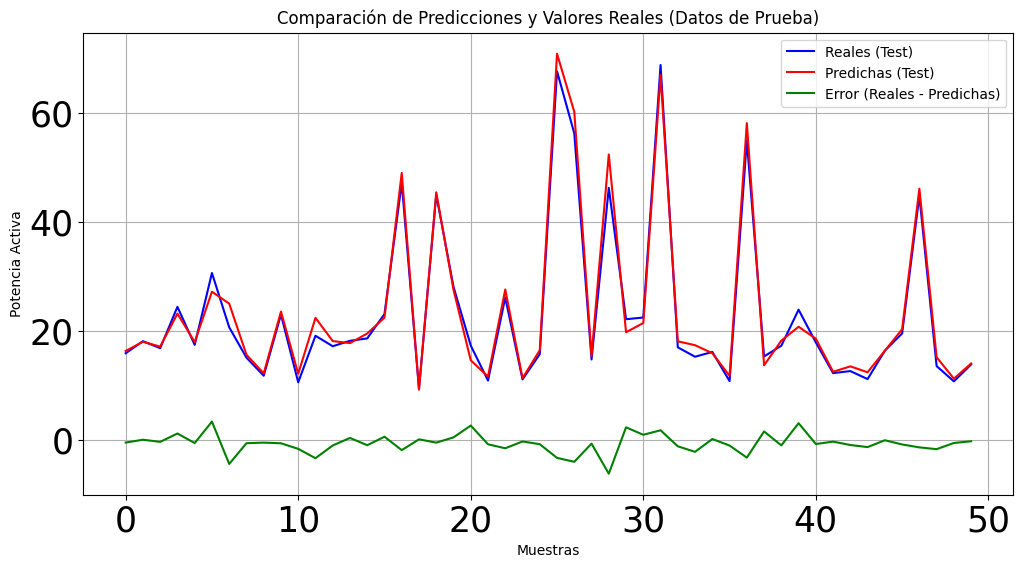

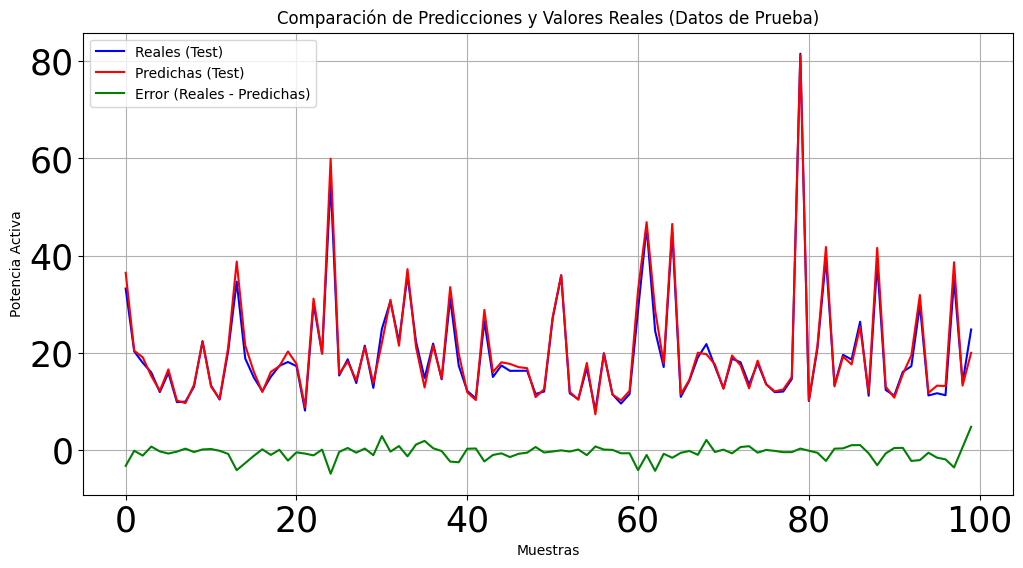

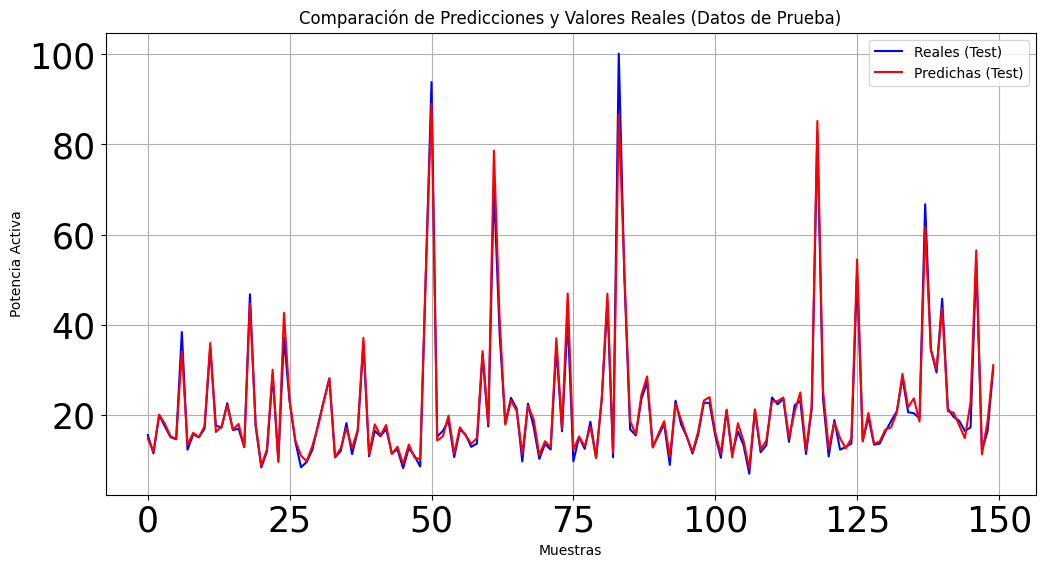

[[-2.14803806]
 [-0.63708267]
 [ 1.55644849]
 ...
 [-3.81874884]
 [ 0.08959185]
 [ 0.49751506]]


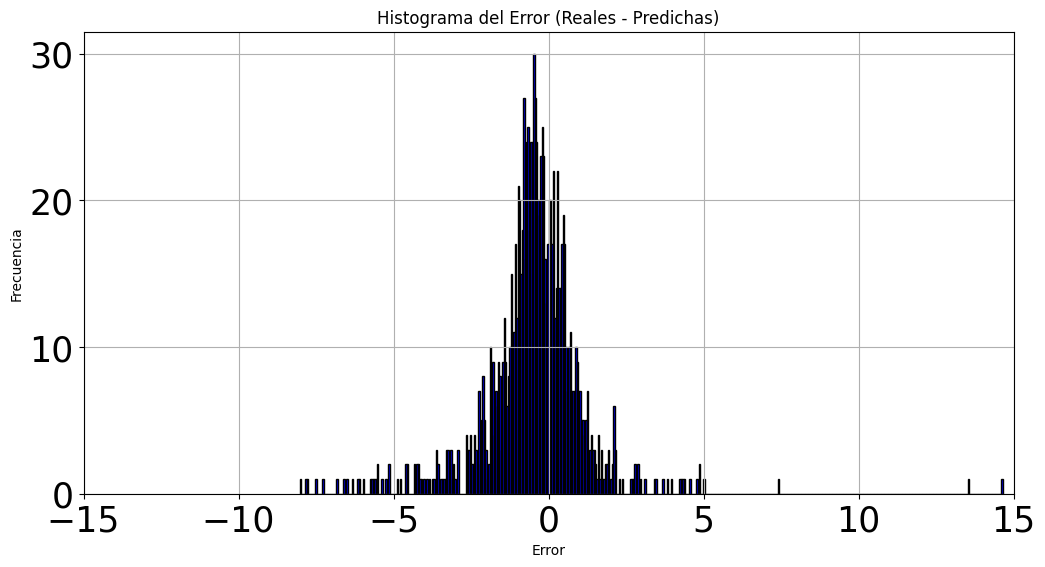

In [402]:
# Plot de datos de prueba
plt.figure(figsize=(12, 6))

# Ploteamos los datos reales y predichos como líneas
plt.plot(y_test, label='Reales (Test)', linestyle='-', color='blue')
plt.plot(y_test_pred, label='Predichas (Test)', linestyle='-', color='red')

# Añadimos título y etiquetas
plt.title('Comparación de Predicciones y Valores Reales (Datos de Prueba)')
plt.xlabel('Muestras')
plt.ylabel('Potencia Activa')

# Añadimos la leyenda y la cuadrícula
plt.legend()
plt.grid(True)

# Mostramos el gráfico
plt.show()



# Calculamos el error (diferencia entre los valores reales y predichos)
error = y_test[:50] - y_test_pred[:50]

# Plot de datos de prueba
plt.figure(figsize=(12, 6))

# Ploteamos los primeros 50 datos reales y predichos como líneas
plt.plot(y_test[:50], label='Reales (Test)', linestyle='-', color='blue')
plt.plot(y_test_pred[:50], label='Predichas (Test)', linestyle='-', color='red')

# Ploteamos el error como línea
plt.plot(error, label='Error (Reales - Predichas)', linestyle='-', color='green')

# Añadimos título y etiquetas
plt.title('Comparación de Predicciones y Valores Reales (Datos de Prueba)')
plt.xlabel('Muestras')
plt.ylabel('Potencia Activa')

# Añadimos la leyenda y la cuadrícula
plt.legend()
plt.grid(True)

# Mostramos el gráfico
plt.show()






# Plot de datos de prueba
plt.figure(figsize=(12, 6))

error = y_test[50:100] - y_test_pred[50:100]

# Ploteamos los primeros 100 datos reales y predichos como líneas
plt.plot(y_test[50:100], label='Reales (Test)', linestyle='-', color='blue')
plt.plot(y_test_pred[50:100], label='Predichas (Test)', linestyle='-', color='red')
plt.plot(error, label='Error (Reales - Predichas)', linestyle='-', color='green')

# Añadimos título y etiquetas
plt.title('Comparación de Predicciones y Valores Reales (Datos de Prueba)')
plt.xlabel('Muestras')
plt.ylabel('Potencia Activa')

# Añadimos la leyenda y la cuadrícula
plt.legend()
plt.grid(True)

# Mostramos el gráfico
plt.show()


# Plot de datos de prueba
plt.figure(figsize=(12, 6))
error = y_test[300:400] - y_test_pred[300:400]

# Ploteamos los primeros 100 datos reales y predichos como líneas
plt.plot(y_test[300:400], label='Reales (Test)', linestyle='-', color='blue')
plt.plot(y_test_pred[300:400], label='Predichas (Test)', linestyle='-', color='red')
plt.plot(error, label='Error (Reales - Predichas)', linestyle='-', color='green')

# Añadimos título y etiquetas
plt.title('Comparación de Predicciones y Valores Reales (Datos de Prueba)')
plt.xlabel('Muestras')
plt.ylabel('Potencia Activa')

# Añadimos la leyenda y la cuadrícula
plt.legend()
plt.grid(True)

# Mostramos el gráfico
plt.show()





# Plot de datos de prueba
plt.figure(figsize=(12, 6))

# Ploteamos los primeros 100 datos reales y predichos como líneas
plt.plot(y_test[850:1000], label='Reales (Test)', linestyle='-', color='blue')
plt.plot(y_test_pred[850:1000], label='Predichas (Test)', linestyle='-', color='red')

# Añadimos título y etiquetas
plt.title('Comparación de Predicciones y Valores Reales (Datos de Prueba)')
plt.xlabel('Muestras')
plt.ylabel('Potencia Activa')

# Añadimos la leyenda y la cuadrícula
plt.legend()
plt.grid(True)

# Mostramos el gráfico
plt.show()


error = y_test - y_test_pred
print((error))


# Creamos un histograma del error
plt.figure(figsize=(12, 6))
plt.xlim(-15, 15)

plt.hist(error, bins=500, edgecolor='black', color='blue')

# Añadimos título y etiquetas
plt.title('Histograma del Error (Reales - Predichas)')
plt.xlabel('Error')
plt.ylabel('Frecuencia')

# Mostramos el gráfico
plt.grid(True)
plt.show()

In [403]:
std_deviation = np.std(error)

print(f"Desviación estándar del error: {std_deviation:.2f}")

Desviación estándar del error: 1.63


In [379]:
min_error = np.min(error)
max_error = np.max(error)


# Encontrar los índices de los valores que tienen un valor absoluto mayor que 1
indices = np.where(np.abs(error) > 0.7)
# Contar cuántos valores cumplen la condición
cont = len(indices[0])

with open("resultados.txt", "w") as file:
    file.write(f"Valor minimo del error: {min_error}\n")
    file.write(f"Valor maximo del error: {max_error}\n")
    file.write(f"Cantidad de valores con modulo mayor que el elegido: {cont}\n")

    file.write("Posiciones y valores:\n")
    for i in range(cont):
        row = indices[0][i]
        col = indices[1][i]
        file.write(f"indice: ({row}, {col}), Valor: {error[row, col]}\n")

In [380]:
# Leer los CSV a partir de la fila 117207 (recordar que skiprows es 0-based)

# Leer los encabezados del archivo
encabezados_corrientes = pd.read_csv('corrientes.csv', nrows=0).columns
encabezados_potencias = pd.read_csv('potencias.csv', nrows=0).columns

#corrientes_nuevas = pd.read_csv('corrientes_nuevo.csv', skiprows=117206, header=None, names=encabezados_corrientes)
#print(corrientes_nuevas)
#potencias_nuevas = pd.read_csv('potencias_nuevo.csv', skiprows=117206, header=None, names=encabezados_potencias)
corrientes_nuevas = pd.read_csv('corrientes_nuevo.csv', skiprows=80000, header=None, names=encabezados_corrientes)
#print(corrientes_nuevas)
potencias_nuevas = pd.read_csv('potencias_nuevo.csv', skiprows=80000, header=None, names=encabezados_potencias)
print(potencias_nuevas)

# Convertir la columna 'timestamp' a datetime
corrientes_nuevas['timestamp'] = pd.to_datetime(corrientes_nuevas['timestamp'])
potencias_nuevas['timestamp'] = pd.to_datetime(potencias_nuevas['timestamp'])

# Unir los dataframes en base al ID y timestamp
df_unido = pd.merge(corrientes_nuevas, potencias_nuevas, on=['id', 'timestamp'])

# Separar la columna de timestamp en año, mes, día, hora, minuto
df_unido['año'] = df_unido['timestamp'].dt.year
df_unido['mes'] = df_unido['timestamp'].dt.month
df_unido['dia'] = df_unido['timestamp'].dt.day
df_unido['hora'] = df_unido['timestamp'].dt.hour
df_unido['minuto'] = df_unido['timestamp'].dt.minute

# Seleccionar y reorganizar las columnas en el formato deseado
df_nuevo = df_unido[['año', 'mes', 'dia', 'hora', 'minuto', 'activa', 'reactiva', 'aparente', 'l1', 'l2', 'l3']]

# Mostrar el dataframe resultante
print(df_nuevo)

         id  activa  reactiva  aparente            timestamp
0      2103  27.024    12.552    29.796  2023-04-14 07:45:00
1      2103  30.684    13.656    33.584  2023-04-14 08:00:00
2      2103  35.520    12.432    37.632  2023-04-14 08:15:00
3      2103  41.520    11.712    43.140  2023-04-14 08:30:00
4      2103  40.956    11.244    42.472  2023-04-14 08:45:00
...     ...     ...       ...       ...                  ...
41350  2103  72.084     1.476    72.100  2024-06-18 14:00:00
41351  2103  73.680     2.880    73.736  2024-06-18 14:15:00
41352  2103  66.384     1.992    66.412  2024-06-18 14:30:00
41353  2103  59.928     1.956    59.960  2024-06-18 14:45:00
41354  2103  58.584     2.520    58.640  2024-06-18 15:00:00

[41355 rows x 5 columns]
        año  mes  dia  hora  minuto  activa  reactiva  aparente      l1  \
0      2023    4   14     7      45  27.024    12.552    29.796   37.23   
1      2023    4   14     8       0  30.684    13.656    33.584   45.78   
2      2023    4 

In [381]:
activaprenueva, activapostnueva = create_windows(df_nuevo['activa'], mediciones_ventana)
aparenteprenueva, aparentepostnueva = create_windows(df_nuevo['aparente'], mediciones_ventana)
reactivaprenueva, reactivapostnueva = create_windows(df_nuevo['reactiva'], mediciones_ventana)
mesprenueva, mespostnueva = create_windows(df_nuevo['mes'], mediciones_ventana)
diaprenueva, diapostnueva = create_windows(df_nuevo['dia'], mediciones_ventana)
minutoprenueva, minutopostnueva = create_windows(df_nuevo['minuto'], mediciones_ventana)
i1prenueva, i1postnueva = create_windows(df_nuevo['l1'], mediciones_ventana)
i2prenueva, i2postnueva = create_windows(df_nuevo['l2'], mediciones_ventana)
i3prenueva, i3postnueva = create_windows(df_nuevo['l3'], mediciones_ventana)

In [382]:
activaprenueva

array([[27.024, 30.684, 35.52 , ..., 40.044, 40.56 , 42.624],
       [30.684, 35.52 , 41.52 , ..., 40.56 , 42.624, 38.388],
       [35.52 , 41.52 , 40.956, ..., 42.624, 38.388, 37.164],
       ...,
       [18.84 , 21.48 , 20.7  , ..., 68.916, 72.084, 73.68 ],
       [21.48 , 20.7  , 19.92 , ..., 72.084, 73.68 , 66.384],
       [20.7  , 19.92 , 21.012, ..., 73.68 , 66.384, 59.928]])

In [383]:
activapostnueva

array([38.388, 37.164, 37.992, ..., 66.384, 59.928, 58.584])

In [384]:
Xnuevo = np.concatenate([activaprenueva, aparenteprenueva, reactivaprenueva, mesprenueva, diaprenueva, minutoprenueva, i1prenueva, i2prenueva, i3prenueva], axis=1)
ynuevo = activapostnueva  # Supongamos que queremos predecir la 'activa' post ventana
ynuevo
ynuevo.shape

(41319,)

In [385]:
Xnuevo

array([[ 27.024,  30.684,  35.52 , ...,  50.76 ,  49.29 ,  51.81 ],
       [ 30.684,  35.52 ,  41.52 , ...,  49.29 ,  51.81 ,  47.22 ],
       [ 35.52 ,  41.52 ,  40.956, ...,  51.81 ,  47.22 ,  45.18 ],
       ...,
       [ 18.84 ,  21.48 ,  20.7  , ...,  95.94 , 102.57 , 104.1  ],
       [ 21.48 ,  20.7  ,  19.92 , ..., 102.57 , 104.1  ,  96.99 ],
       [ 20.7  ,  19.92 ,  21.012, ..., 104.1  ,  96.99 ,  82.05 ]])

In [386]:
Xnuevo = scalerX.fit_transform(Xnuevo)



In [387]:
Xnuevo

array([[ 0.10575058,  0.33529865,  0.63860406, ...,  0.4866795 ,
         0.41671858,  0.53642824],
       [ 0.33528829,  0.63858908,  1.01489508, ...,  0.41680689,
         0.53649009,  0.31828282],
       [ 0.6385791 ,  1.01487993,  0.97952373, ...,  0.5365885 ,
         0.31833484,  0.2213293 ],
       ...,
       [-0.40751078, -0.24193151, -0.29083478, ...,  2.63419259,
         2.94903048,  3.02157512],
       [-0.2419426 , -0.29084932, -0.33975261, ...,  2.94933229,
         3.02174889,  2.68366359],
       [-0.29086047, -0.33976713, -0.27126764, ...,  3.02205684,
         2.68382214,  1.97362162]])

In [388]:
Xnuevo_desescalado = scalerX.inverse_transform(Xnuevo)
print(Xnuevo_desescalado)


[[ 27.024  30.684  35.52  ...  50.76   49.29   51.81 ]
 [ 30.684  35.52   41.52  ...  49.29   51.81   47.22 ]
 [ 35.52   41.52   40.956 ...  51.81   47.22   45.18 ]
 ...
 [ 18.84   21.48   20.7   ...  95.94  102.57  104.1  ]
 [ 21.48   20.7    19.92  ... 102.57  104.1    96.99 ]
 [ 20.7    19.92   21.012 ... 104.1    96.99   82.05 ]]


In [389]:
#y_test_prednuevo = model.predict(Xnuevo[0,:].reshape(1, -1))
y_test_prednuevo = model.predict(Xnuevo)
y_test_prednuevo = scalery.inverse_transform(y_test_prednuevo)
#y_test_prednuevo = y_test_prednuevo + 20


1292/1292 [==============================] - 4s 3ms/step


In [390]:
ynuevo

array([38.388, 37.164, 37.992, ..., 66.384, 59.928, 58.584])

In [391]:
y_test_prednuevo

array([[35.05116 ],
       [32.02052 ],
       [31.581366],
       ...,
       [60.44961 ],
       [54.966473],
       [50.349697]], dtype=float32)

In [392]:
ynuevo = ynuevo.reshape(-1, 1)


In [393]:
mse = mean_squared_error(ynuevo, y_test_prednuevo)



# Calculamos otras métricas de error
mae = mean_absolute_error(ynuevo, y_test_prednuevo)
rmse = np.sqrt(mse)
r2 = r2_score(ynuevo, y_test_prednuevo)

# Imprimimos las métricas de error
print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'R²: {r2}')

# Definimos un margen de error aceptable (por ejemplo, 10 unidades) 12.45
margin_of_error = 4

# Calculamos cuántas predicciones están dentro del margen de error
within_margin = np.sum(np.abs(ynuevo - y_test_prednuevo) <= margin_of_error)
total_predictions = len(ynuevo)
accuracy_within_margin = within_margin / total_predictions

# Imprimimos la precisión dentro del margen de error
print(f'Número de predicciones dentro del margen de error: {within_margin}')
print(f'Precisión dentro del margen de error: {accuracy_within_margin:.2%}')

MSE: 24.878731181654803
MAE: 4.023111818866475
RMSE: 4.987858376262783
R²: 0.9022695103484002
Número de predicciones dentro del margen de error: 27545
Precisión dentro del margen de error: 66.66%


In [394]:
ynuevo.shape

(41319, 1)

In [395]:
ynuevo.shape

(41319, 1)

In [396]:
ynuevo
ynuevo.shape
y_test_prednuevo.shape

(41319, 1)

In [397]:
error = ynuevo[0:4145] - y_test_prednuevo[0:4145]
print(error)
error.shape

[[3.33684109]
 [5.14348074]
 [6.41063441]
 ...
 [1.85378967]
 [3.45159951]
 [2.84158591]]


(4145, 1)

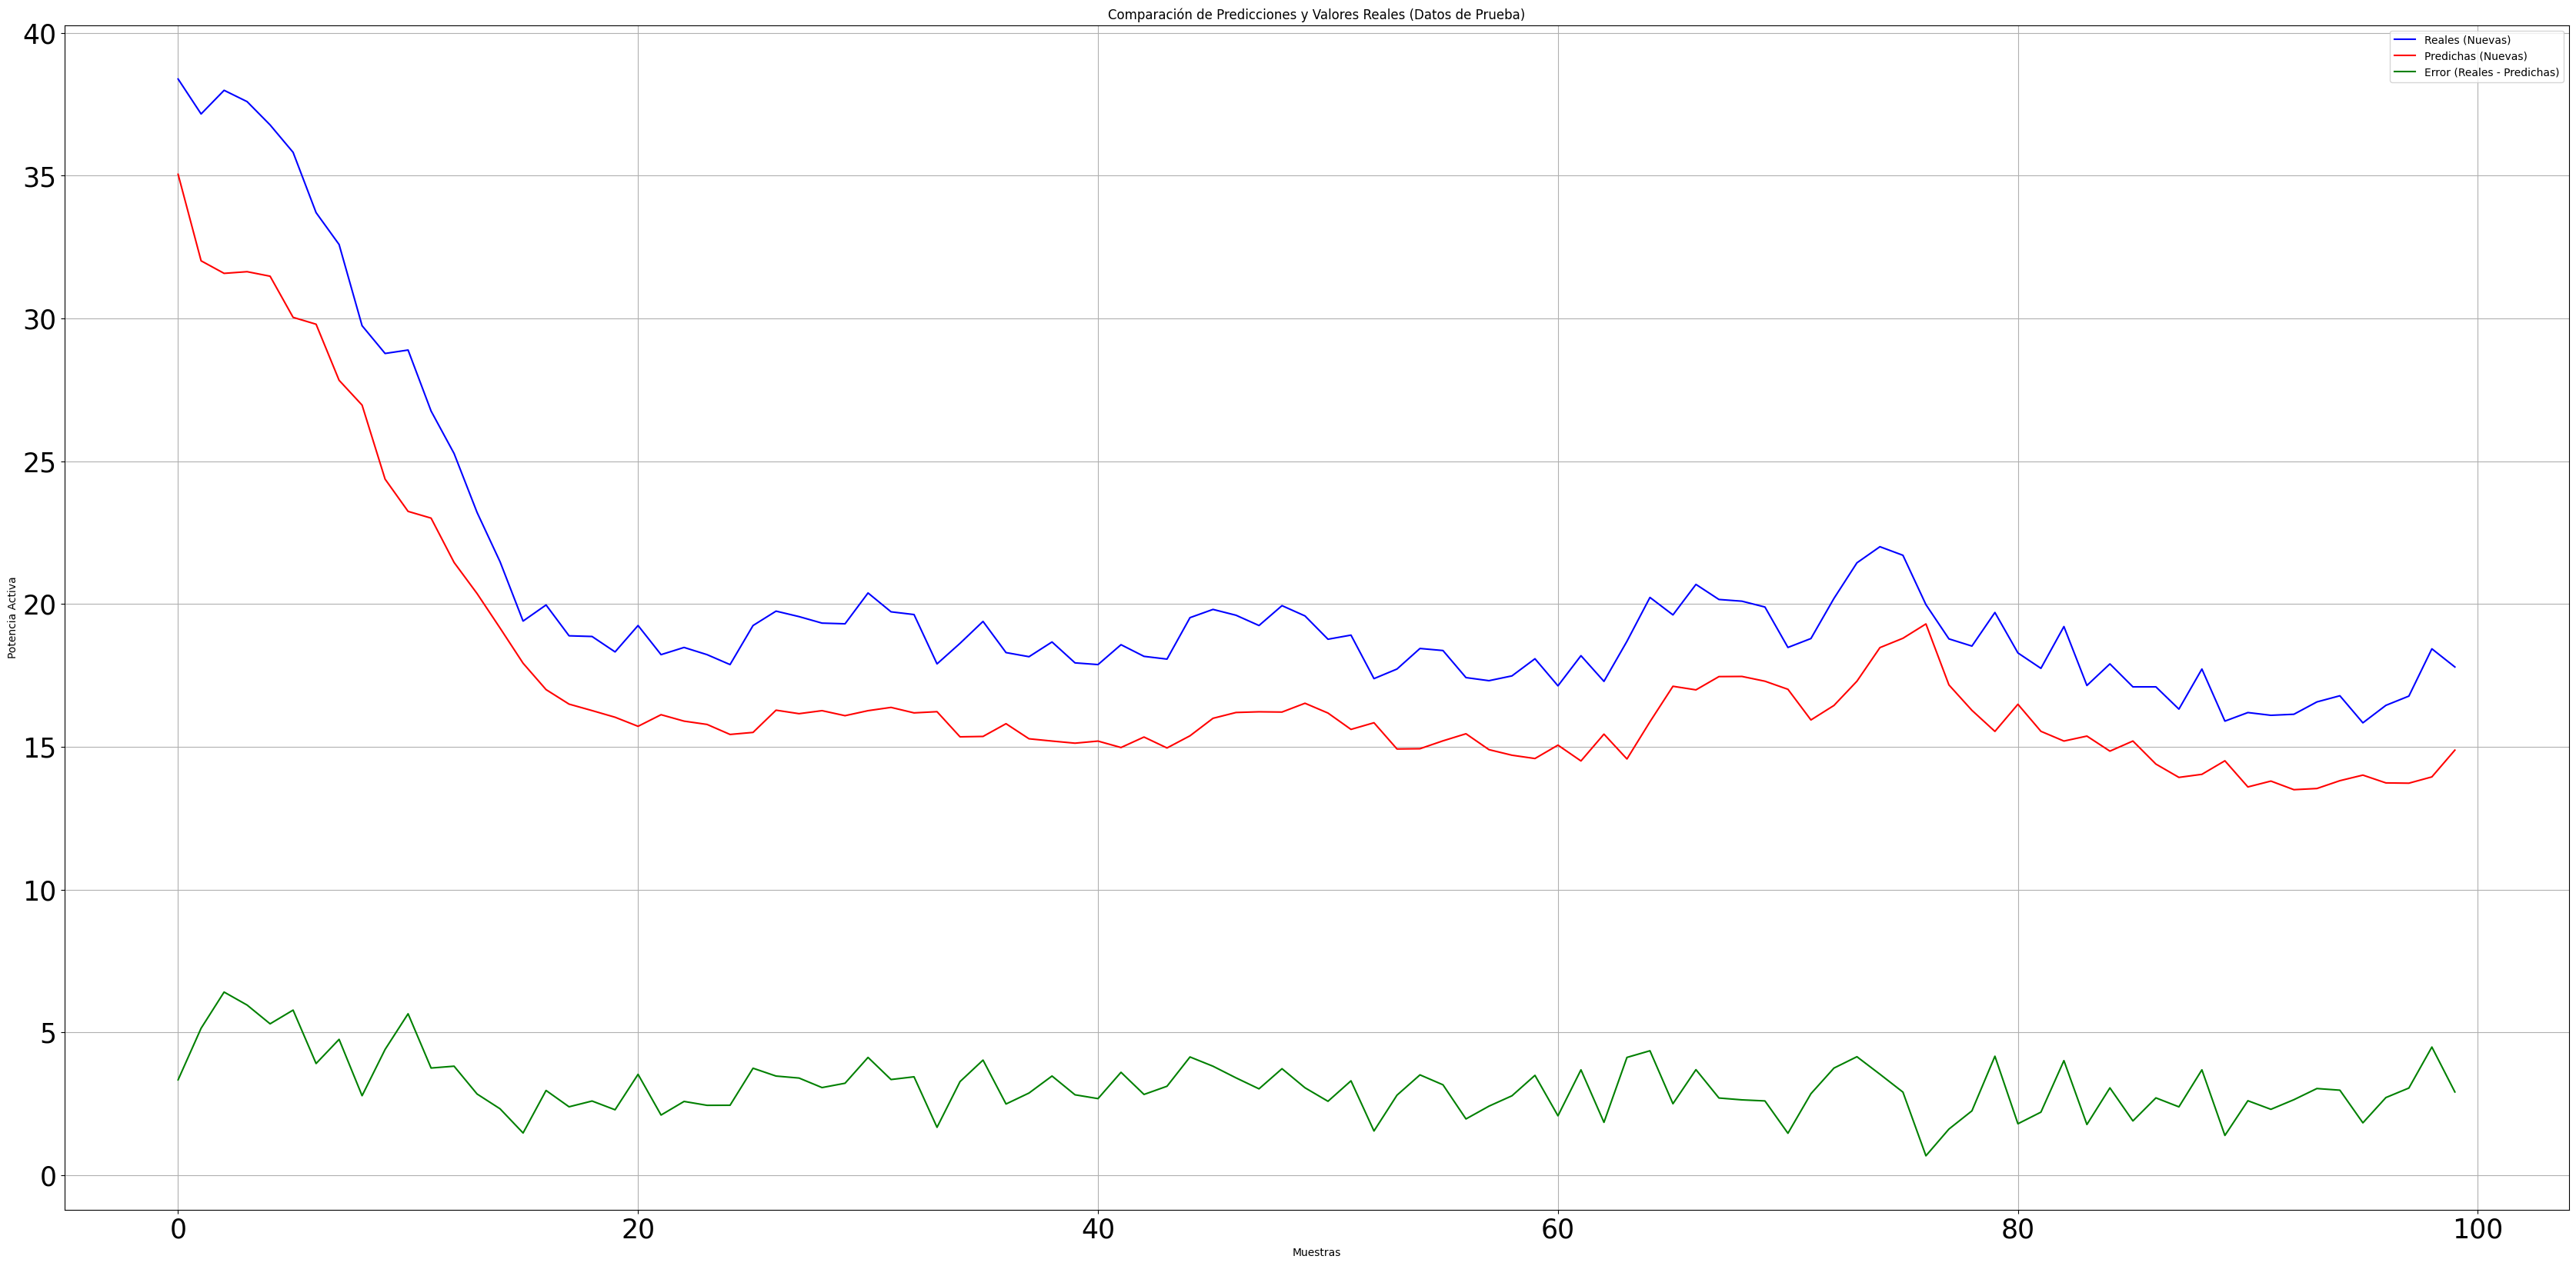

In [398]:
# Plot de datos de prueba 117207 121351 datos nuevos aprox 4000 ultimos
plt.figure(figsize=(42, 20))
error = ynuevo[0:100] - y_test_prednuevo[0:100]

# Ploteamos los primeros 100 datos reales y predichos como líneas
plt.plot(ynuevo[0:100], label='Reales (Nuevas)', linestyle='-', color='blue')
plt.plot(y_test_prednuevo[0:100], label='Predichas (Nuevas)', linestyle='-', color='red')
plt.plot(error, label='Error (Reales - Predichas)', linestyle='-', color='green')

# Añadimos título y etiquetas
plt.title('Comparación de Predicciones y Valores Reales (Datos de Prueba)')
plt.xlabel('Muestras')
plt.ylabel('Potencia Activa')

# Añadimos la leyenda y la cuadrícula
plt.legend()
plt.grid(True)

# Mostramos el gráfico
plt.show()

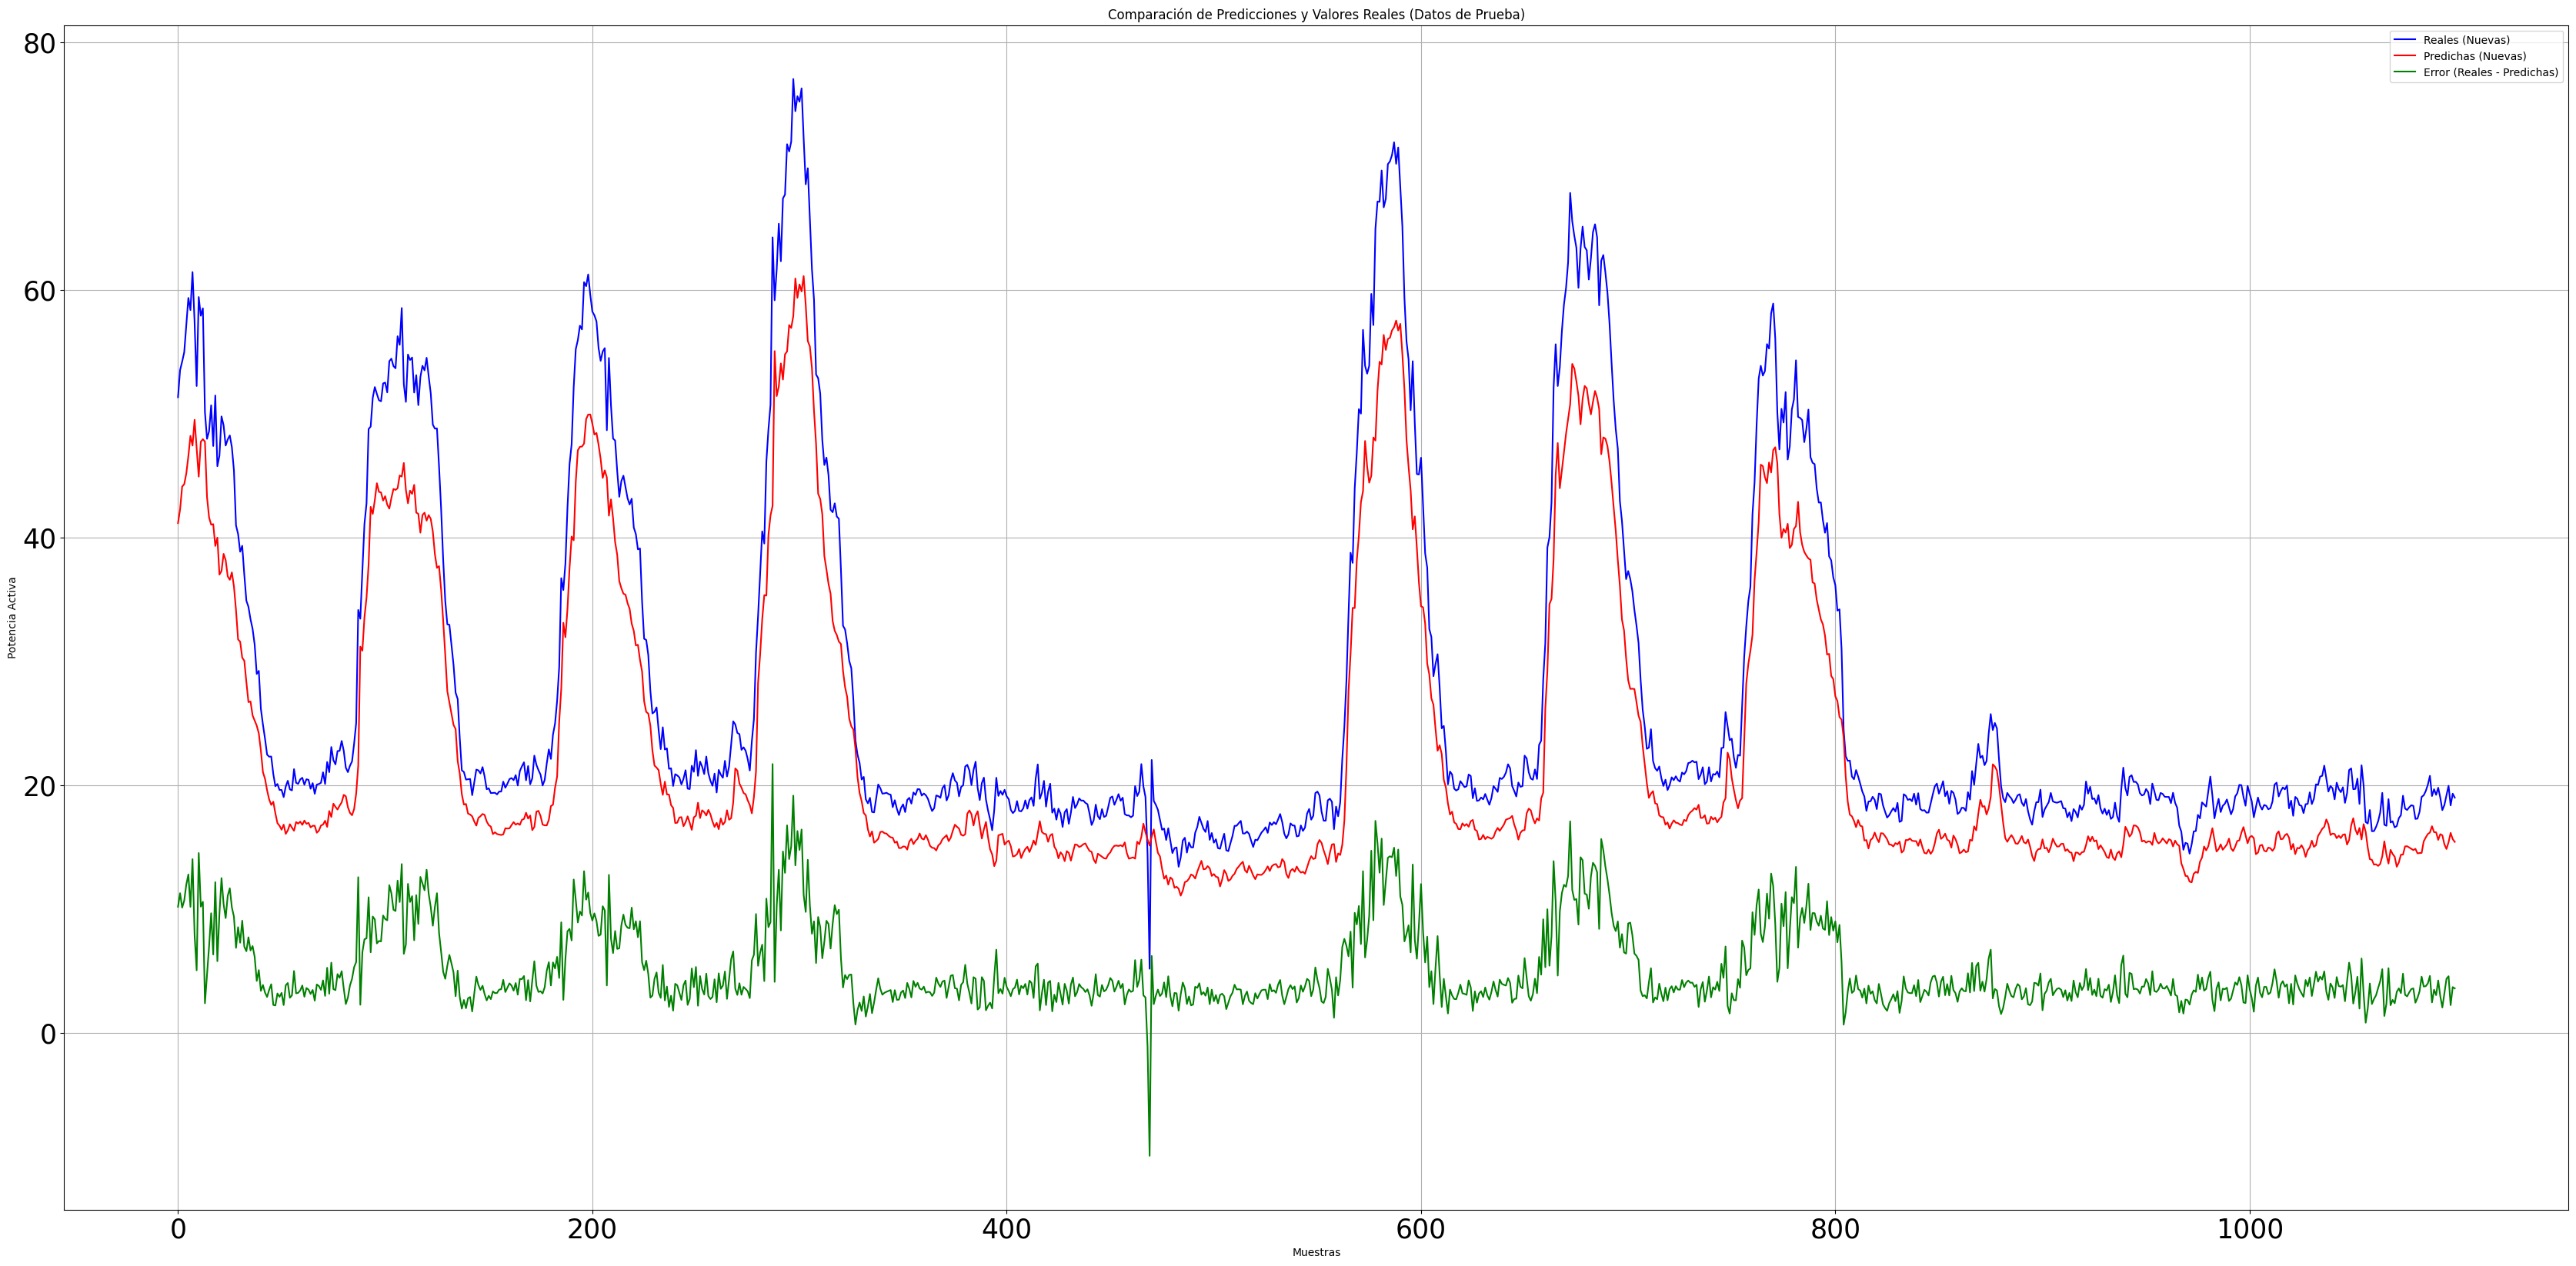

In [325]:
# Plot de datos de prueba 117207 121351 datos nuevos aprox 4000 ultimos
plt.figure(figsize=(42, 20))
error = ynuevo[3045:4145] - y_test_prednuevo[3045:4145]

# Ploteamos los primeros 100 datos reales y predichos como líneas
plt.plot(ynuevo[3045:4145], label='Reales (Nuevas)', linestyle='-', color='blue')
plt.plot(y_test_prednuevo[3045:4145], label='Predichas (Nuevas)', linestyle='-', color='red')
plt.plot(error, label='Error (Reales - Predichas)', linestyle='-', color='green')

# Añadimos título y etiquetas
plt.title('Comparación de Predicciones y Valores Reales (Datos de Prueba)')
plt.xlabel('Muestras')
plt.ylabel('Potencia Activa')

# Añadimos la leyenda y la cuadrícula
plt.legend()
plt.grid(True)

# Mostramos el gráfico
plt.show()


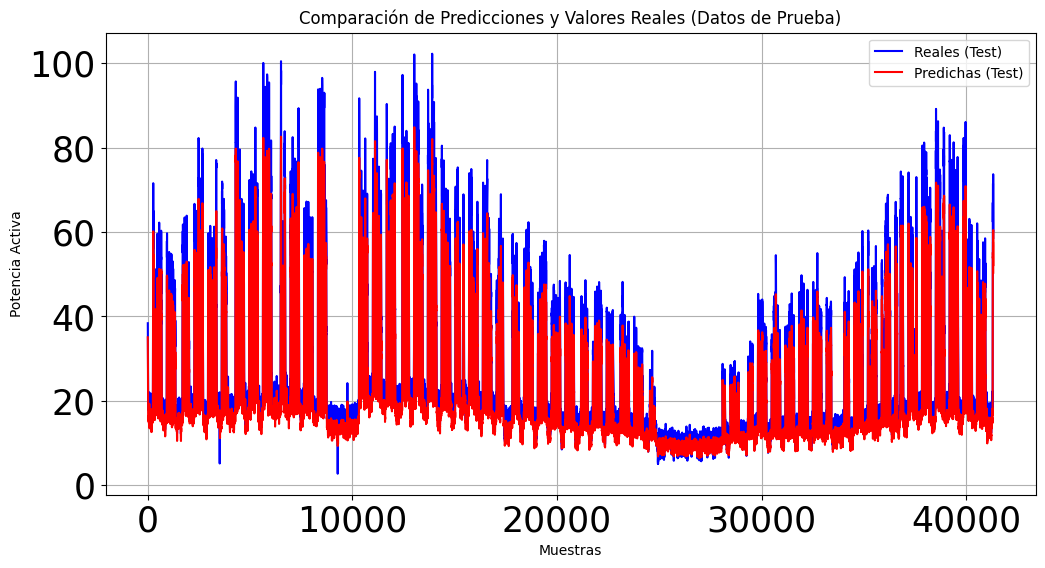

In [399]:
# Plot de datos de prueba
plt.figure(figsize=(12, 6))
error = ynuevo - y_test_prednuevo

# Ploteamos los primeros 100 datos reales y predichos como líneas
plt.plot(ynuevo, label='Reales (Test)', linestyle='-', color='blue')
plt.plot(y_test_prednuevo, label='Predichas (Test)', linestyle='-', color='red')
#plt.plot(error, label='Error (Reales - Predichas)', linestyle='-', color='green')

# Añadimos título y etiquetas
plt.title('Comparación de Predicciones y Valores Reales (Datos de Prueba)')
plt.xlabel('Muestras')
plt.ylabel('Potencia Activa')

# Añadimos la leyenda y la cuadrícula
plt.legend()
plt.grid(True)

# Mostramos el gráfico
plt.show()

In [400]:
min_error = np.min(error)
max_error = np.max(error)


# Encontrar los índices de los valores que tienen un valor absoluto mayor que 1
indices = np.where(np.abs(error) > 1)
# Contar cuántos valores cumplen la condición
cont = len(indices[0])

with open("resultados_nuevos.txt", "w") as file:
    file.write(f"Valor minimo del error: {min_error}\n")
    file.write(f"Valor maximo del error: {max_error}\n")
    file.write(f"Cantidad de valores con modulo mayor que el elegido: {cont}\n")

    file.write("Posiciones y valores:\n")
    for i in range(cont):
        row = indices[0][i]
        col = indices[1][i]
        file.write(f"indice: ({row}, {col}), Valor: {error[row, col]}\n")

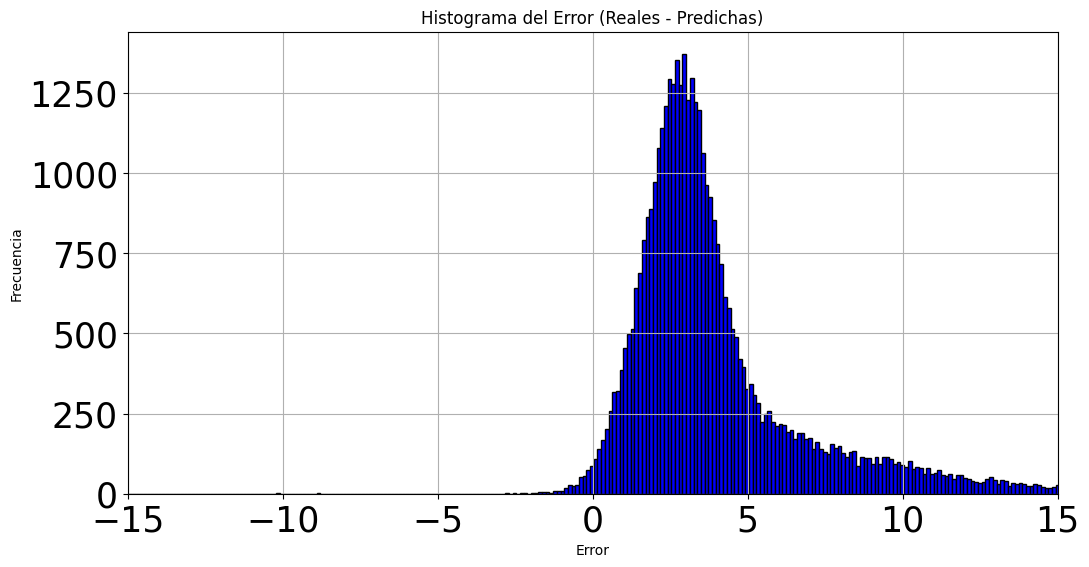

Desviación estándar del error: 2.96
med del error: 4.01


In [401]:
# Creamos un histograma del error
plt.figure(figsize=(12, 6))
plt.xlim(-15, 15)

plt.hist(error, bins=500, edgecolor='black', color='blue')

# Añadimos título y etiquetas
plt.title('Histograma del Error (Reales - Predichas)')
plt.xlabel('Error')
plt.ylabel('Frecuencia')

# Mostramos el gráfico
plt.grid(True)
plt.show()

std_deviation = np.std(error)
med = np.mean(error)
print(f"Desviación estándar del error: {std_deviation:.2f}")
print(f"med del error: {med:.2f}")

In [320]:
ynuevo.shape

(41319, 1)

In [327]:
error2 = ynuevo[37319:41319]- y_test_prednuevo[37319:41319]
print(error2[3000])

[-4.27246093e-07]


In [321]:
mse = mean_squared_error(ynuevo[37319:41319], y_test_prednuevo[37319:41319])



# Calculamos otras métricas de error
mae = mean_absolute_error(ynuevo[37319:41319], y_test_prednuevo[37319:41319])
rmse = np.sqrt(mse)
r2 = r2_score(ynuevo[37319:41319], y_test_prednuevo[37319:41319])

# Imprimimos las métricas de error
print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'R²: {r2}')

# Definimos un margen de error aceptable (por ejemplo, 10 unidades) 12.45
margin_of_error = 4

# Calculamos cuántas predicciones están dentro del margen de error
within_margin = np.sum(np.abs(ynuevo[37319:41319], y_test_prednuevo[37319:41319]) <= margin_of_error)
total_predictions = len(ynuevo[37319:41319])
accuracy_within_margin = within_margin / total_predictions

# Imprimimos la precisión dentro del margen de error
print(f'Número de predicciones dentro del margen de error: {within_margin}')
print(f'Precisión dentro del margen de error: {accuracy_within_margin:.2%}')

MSE: 53.82524628399056
MAE: 5.812492238832474
RMSE: 7.336569108513227
R²: 0.8298811252250571
Número de predicciones dentro del margen de error: 0
Precisión dentro del margen de error: 0.00%
